# Privacy - attack model - part1 : Wasserstein GAN

reference for the WGAN : https://machinelearningmastery.com/how-to-code-a-wasserstein-generative-adversarial-network-wgan-from-scratch/

# Imports and Data

In [1]:
%load_ext autoreload
%autoreload 2

from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import pandas as pd

from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras import backend
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Add
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras.initializers import RandomNormal

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot
import numpy as np
import os
import re
import matplotlib.pyplot as plt

os.sys.path.append("./src")
from utils import plot_img
from utils import load_mnist_data
from utils import pick_and_show_image
from models import define_critic

from models import define_critic
from models import generate_latent_points

# 1. Load private data

In [2]:
# x_train, y_train, x_test, y_test = load_mnist_data("private")

# 2. Load models

## 2.1 load the model attacked

In [3]:
target_model = load_model("model/target_model_1583961212.741507.h5")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## 2.2 load the critic

We choose the id of the model. For example we choose the last one

As the critic model is customed we build up a new model with the same architecture as the critic, load the weights of the one saved and load them into the new one.

In [4]:
model_id = 13770
attack_critic_model = define_critic()
attack_critic_model.load_weights("model/attack_critic_model_weights_" + str(model_id) + ".h5")
attack_critic_model._name = "attack_critic_model"

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
print(attack_critic_model.name)

attack_critic_model


## 2.3 load the gan

We use two gan with different names so that the model do not have the same layers' name when combined in the optimization model

In [6]:
attack_gan_model_1 = load_model("model/attack_gan_model_" + str(model_id) + ".h5")
attack_gan_model_1._name = "attack_gan_model_1"
print(attack_gan_model_1.name)

attack_gan_model_2 = load_model("model/attack_gan_model_" + str(model_id) + ".h5")
attack_gan_model_2._name = "attack_gan_model_2"
print(attack_gan_model_2.name)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
attack_gan_model_1
attack_gan_model_2


# 3. Define optimization process

## 3.1 Define the model

We design a model which intermediate layer is of the dimension of the latent space. We want to generate a point in the latent space (__x__) that makes the generator produce a credible image (hand written-digit-like) which will be classified by the target model as the target label.
The outputs of the model are chosen to build a loss designed to perform this optimization program :
- __attack_critic_model(attack_gan_model_1(x))__ which the critic of the image generated by the GAN, the more the image is credible, the higher will be this output ;
- __target_model(attack_gan_model_2(x))__ which the class predicted by the target model, this one will be used to compute a difference with the label targetted

In [7]:
def create_new_model_optim(random_init_dim=1, 
                           attack_critic_model=attack_critic_model, 
                           attack_gan_model_1=attack_gan_model_1, 
                           attack_gan_model_2=attack_gan_model_2):
    
    # generate a point in the latent space
    main_input = Input(shape = (random_init_dim, ), name='main_input')
    x = Dense(50,
              activation='linear',
              kernel_initializer = RandomNormal(mean=0.0, stddev=1, seed=None),
              name = "gen_attack_img")(main_input)
    gen_latent_values = Model(main_input, x)

    # build up the model with the outputs that will be used to compute the loss
    model = Model(inputs=main_input, outputs = [attack_critic_model(attack_gan_model_1(x)),
                                                target_model(attack_gan_model_2(x))])
    print(model.summary())
    return model, gen_latent_values

Only one layer should be trainable to perform the optimization process. If not we will retrain our models.

In [8]:
def freeze_not_optim_layers(model):
    for layer in model.layers:
        if layer.name == "gen_attack_img":
            layer.trainable=True
        else:
            layer.trainable=False
        # print("layer : {}, trainable {}".format(layer.name, layer.trainable))

    return model

## 3.2 Define the loss

The loss is compound of two parts :
- the credibility : is the image reconstructed a credible hand written digit ?
- the class proximity : is the class of the reconstructed image, the one targetted ?

In [9]:
def loss_optim_fn(target, lambda_):
    def loss_optim(y_true, y_pred):
        # target.shape -> (5,)
        # y_pred is a list with
        # y_pred[0].shape -> (500, 1)
        # y_pred[1].shape -> (500, 5)
        # credibility part : this part caracterize the credibility of the reconstructed image in the space of the public data
        credibility = backend.mean(y_pred[0], axis=0)
        # credibility.shape -> (1,)
        
        # proximity part : define the absolute difference between the predicted for the reconstructed image and the class targetted
        # backend.mean(y_pred[1], axis=0).shape -> (5,)
        proximity_to_target = backend.mean(y_pred[1], axis=0) - target
        proximity_to_target = backend.abs(proximity_to_target)
        proximity_to_target = backend.mean(proximity_to_target)/2
        return backend.sum([credibility, lambda_*backend.log(proximity_to_target)], axis=-1)
    return loss_optim

# 4. Launch the whole process

In [10]:
# optim parameters
lambda_ = 100
n_epochs = 150

# inputs are constants and ouputs are not used
x = np.full((500, 1), 1)
model, _ = create_new_model_optim()
y = model.predict(np.full((500, 1), 1)) # we do not use these values, there are just here to avoid errors when training the model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
gen_attack_img (Dense)          (None, 50)           100         main_input[0][0]                 
__________________________________________________________________________________________________
attack_gan_model_1 (Sequential) (None, 28, 28, 1)    851713      gen_attack_img[0][0]             
__________________________________________________________________________________________________
attack_gan_model_2 (Sequential) (None, 28, 28, 1)    851713      gen_attack_img[0][0]             
____________________________________________________________________________________________

In [11]:
x.shape

(500, 1)

## 4.2 Set parameters

In [ ]:
# img, label = pick_and_show_image(x_train, y_train)
# target_probs = target_model.predict(np.reshape(img,(1,28,28,1)))
# print("target probs : {}".format(target_probs[0]))

In [12]:
target_probs = np.array([0, 0, 1, 0, 0])
target_probs

array([0, 0, 1, 0, 0])

In [22]:
target_probs.shape

(5,)

## 4.2 Make the optimization

The optimization is repeated 5 times. The trial with best results is chosen.

In [13]:
loss = loss_optim_fn(target_probs, lambda_)
optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) # adam à tester
batch_size = 32

latent_reconstructed_list = []
loss_list = []
loss_1_list = []
loss_2_list = []
    
# for i in range(5) :
optim_model, gen_latent_values = create_new_model_optim()
optim_model = freeze_not_optim_layers(model)
optim_model.compile(optimizer=optimizer,loss=loss)
optim_model.fit(x, y, epochs=n_epochs, batch_size = batch_size)

latent_reconstructed = gen_latent_values.predict(np.full((1, 1), 1))
image_reconstructed = attack_gan_model_2.predict(latent_reconstructed)
credibility = attack_critic_model.predict(image_reconstructed)
gen_probs = target_model.predict(image_reconstructed)


latent_reconstructed_list.append(latent_reconstructed)

y_pred = optim_model.predict(x)
loss_result_1 = np.mean(y_pred[1], axis=0) - target_probs
loss_result_1 = np.abs(loss_result_1)
loss_result_1 = np.mean(loss_result_1)/2
loss_result_1 = lambda_*loss_result_1
loss_1_list.append(loss_result_1)

loss_result_2 = np.mean(y_pred[0], axis=0)
loss_2_list.append(loss_result_2)

loss_result = loss_result_1 + loss_result_2
loss_list.append(loss_result)

print("credibility : {}".format(credibility))
print("classification : {}".format(gen_probs))
print("\n \n")

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
gen_attack_img (Dense)          (None, 50)           100         main_input[0][0]                 
__________________________________________________________________________________________________
attack_gan_model_1 (Sequential) (None, 28, 28, 1)    851713      gen_attack_img[0][0]             
__________________________________________________________________________________________________
attack_gan_model_2 (Sequential) (None, 28, 28, 1)    851713      gen_attack_img[0][0]             
____________________________________________________________________________________________

In [23]:
y_pred[0].shape

(500, 1)

In [21]:
y_pred[1].shape

(500, 5)

In [14]:
latent_reconstructed

array([[-0.5180685 ,  1.2450972 ,  1.0867869 ,  1.8320887 ,  0.43084836,
         0.32128102, -0.09177265, -0.06413436, -0.29362363, -0.10217059,
         0.7630002 ,  0.69438285,  0.5637195 , -1.7794447 , -0.8937026 ,
        -1.0699247 , -0.21886955,  0.43364078,  1.6941183 ,  1.6351371 ,
        -0.09885251,  0.21657217, -0.50902194, -1.8786974 , -0.8786869 ,
        -1.110442  ,  0.62529135, -0.43939352,  1.3448558 , -0.96616405,
        -0.4239976 , -1.4055173 , -0.517407  , -0.15063538, -0.8318425 ,
         0.48744097, -0.4431982 , -1.0564091 ,  0.08171992, -1.2753817 ,
         0.03256752,  1.1668969 ,  0.6350757 , -0.66358364, -0.85985774,
         0.7011507 ,  0.15999384, -0.39931622,  1.8776681 ,  0.04447875]],
      dtype=float32)

Choose the best one and save the experience

In [15]:
image_reconstructed = attack_gan_model_2.predict(latent_reconstructed)

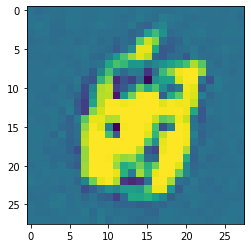

In [16]:
plt.imshow(image_reconstructed[0,:,:,0])

# 5 Save the results

In [ ]:
if not "results" in os.listdir("./"):
    os.mkdir("results")
file_name = "result_" + str(len(os.listdir("./results")))
dir_name = "./results"
file_path = os.path.join(dir_name, file_name)
np.save(file_path, results)